# Rasterio

## Intro

## Summary

# Setup

In [1]:
import rasterio as rio
import rioxarray as rioxr
from rioxarray.merge import merge_arrays

import numpy as np

# Read

In [3]:
tile_1 = rioxr.open_rasterio('zip+http://www.dsr.inpe.br/topodata/data/geotiff/22S465ZN.zip!/22S465ZN.tif')
tile_2 = rioxr.open_rasterio('zip+http://www.dsr.inpe.br/topodata/data/geotiff/23S465ZN.zip!/23S465ZN.tif')
tile_3 = rioxr.open_rasterio('zip+http://www.dsr.inpe.br/topodata/data/geotiff/22S48_ZN.zip!/22S48_ZN.tif')
tile_4 = rioxr.open_rasterio('zip+http://www.dsr.inpe.br/topodata/data/geotiff/23S48_ZN.zip!/23S48_ZN.tif')

## Reproject

In [4]:
tile_1.rio.write_crs('epsg:4326', inplace = True)
tile_2.rio.write_crs('epsg:4326', inplace = True)
tile_3.rio.write_crs('epsg:4326', inplace = True)
tile_4.rio.write_crs('epsg:4326', inplace = True)

<xarray.DataArray (band: 1, y: 3600, x: 5400)>
[19440000 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -48.0 -48.0 -48.0 -48.0 ... -46.5 -46.5 -46.5 -46.5
  * y            (y) float64 -23.0 -23.0 -23.0 -23.0 ... -24.0 -24.0 -24.0 -24.0
    spatial_ref  int32 0
Attributes:
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        IDRISI KILIMANJARO
    TIFFTAG_XRESOLUTION:     87.699997
    TIFFTAG_YRESOLUTION:     87.699997
    scale_factor:            1.0
    add_offset:              0.0

## Mosaic

In [5]:

# Merge/Mosaic multiple rasters using merge_arrays method of rioxarray
merged_raster = rioxr.merge.merge_arrays(dataarrays = [tile_1, tile_2, tile_3, tile_4],
                                        #  res = (90, 90),
                                         crs="EPSG:4326",
                                        nodata = 0
                                         )
 
# Save Raster to disk
merged_raster.rio.to_raster("../data/tmp/merged.tiff")

In [67]:
# path = "../data/tmp/merged.tiff"
# ds = rioxr.open_rasterio(path).squeeze()
# img = ds.plot(cmap="Greys", add_colorbar=False)

## Clip
- https://carpentries-incubator.github.io/geospatial-python/08-crop-raster-data/index.html

In [2]:
path = "../data/tmp/merged.tiff"
ds = rioxr.open_rasterio(path)

In [3]:
from matplotlib import pyplot as plt
import geopandas as gpd
df_jaguari_basin = gpd.read_file('../data/vector/ide_0102_pj_otto_bacia_pol.zip')
# Filter the drainage area of Jaguari river
df_jaguari_basin = df_jaguari_basin[df_jaguari_basin['nunivotto5'].isin(['86669'])].dissolve()
# df_jaguari_basin.to_file('../data/tmp/jaguari_basin.shp')

ValueError: A 3-dimensional array was passed to imshow(), but there is no dimension that could be color.  At least one dimension must be of size 3 (RGB) or 4 (RGBA), and not given as x or y.

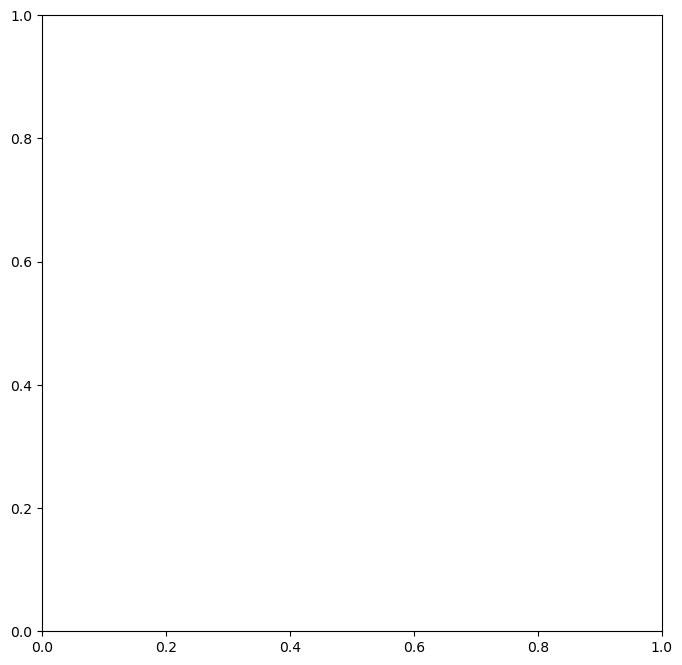

In [4]:

# Convert the coordinate system
df_jaguari_basin = df_jaguari_basin.to_crs(ds.rio.crs)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches((8,8))

# Plot image
ds.plot.imshow(ax=ax,cmap="Greys", add_colorbar=False)

# Plot crop fields
df_jaguari_basin.plot(
    ax=ax,
    edgecolor="red",
    facecolor="none"
)

In [7]:
mde_clip = ds.rio.clip(df_jaguari_basin['geometry'])


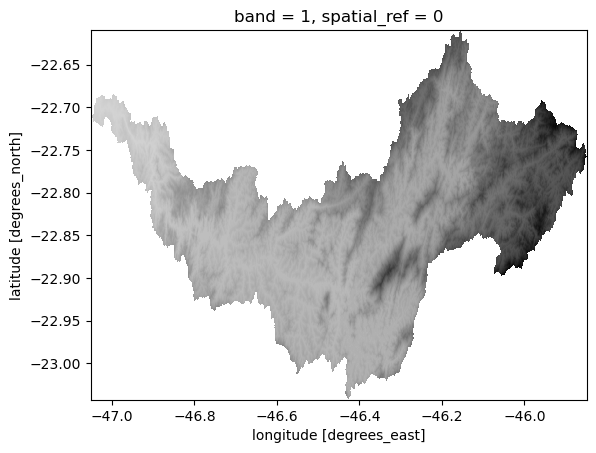

In [9]:
img = mde_clip.plot(cmap="Greys", add_colorbar=False)

## Vectorize

In [ ]:
# Função para poligonizar raster
def polygonize(raster_file):
  img = gdal.Open(raster_file)
  dn = img.GetRasterBand(1)
  shp_driver = ogr.GetDriverByName("ESRI Shapefile")

  shape_out = shp_driver.CreateDataSource('segs.shp')
  srs = ogr.osr.SpatialReference()
  srs.ImportFromEPSG(32723)
  novo_shape = shape_out.CreateLayer('segs.shp', srs = srs)
  gdal.Polygonize(dn, None, novo_shape, -1, [], callback=None)
  shape_out.Destroy()
  return print('Polígonos criados!')